# WESAD 
    TODO:
        - standardize data (by subject)
        - add early stop
check this link: https://github.com/MITMediaLabAffectiveComputing/eda-explorer

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import torch
import torch.nn as nn

class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(16, 64),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.ReLU(),
                        nn.Linear(128, 3),
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)

In [2]:
import torch
import os
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset

class WESADDataset(Dataset):
    def __init__(self):
        self.dataframe = pd.read_csv('m9_feats3.csv', index_col=0)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
        
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader       

In [4]:
dataset = WESADDataset()

batch_size = 15

train_loader, validation_loader = get_training_and_validation_loaders(dataset, batch_size=batch_size)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 150
learning_rate = 1e-4
model = StressNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/150], Loss: 3.393, Acc: 0.31
Epoch [2/150], Loss: 2.26, Acc: 0.46
Epoch [3/150], Loss: 1.383, Acc: 0.49
Epoch [4/150], Loss: 1.546, Acc: 0.38
Epoch [5/150], Loss: 1.26, Acc: 0.44
Epoch [6/150], Loss: 1.24, Acc: 0.47
Epoch [7/150], Loss: 1.219, Acc: 0.5
Epoch [8/150], Loss: 1.224, Acc: 0.5
Epoch [9/150], Loss: 1.117, Acc: 0.51
Epoch [10/150], Loss: 1.107, Acc: 0.53
Epoch [11/150], Loss: 1.107, Acc: 0.57
Epoch [12/150], Loss: 1.288, Acc: 0.54
Epoch [13/150], Loss: 1.078, Acc: 0.59
Epoch [14/150], Loss: 0.9677, Acc: 0.57
Epoch [15/150], Loss: 1.05, Acc: 0.57
Epoch [16/150], Loss: 1.077, Acc: 0.57
Epoch [17/150], Loss: 1.077, Acc: 0.6
Epoch [18/150], Loss: 1.143, Acc: 0.57
Epoch [19/150], Loss: 0.9725, Acc: 0.6
Epoch [20/150], Loss: 1.075, Acc: 0.59
Epoch [21/150], Loss: 1.028, Acc: 0.56
Epoch [22/150], Loss: 1.165, Acc: 0.56
Epoch [23/150], Loss: 1.274, Acc: 0.56
Epoch [24/150], Loss: 1.206, Acc: 0.56
Epoch [25/150], Loss: 1.089, Acc: 0.56
Epoch [26/150], Loss: 1.207, Acc: 0.56
E

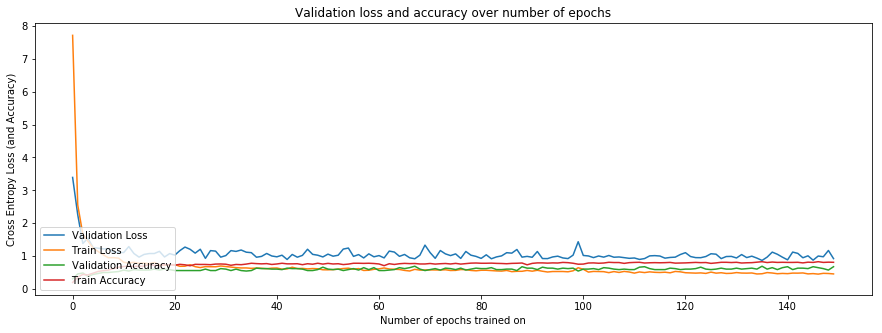

In [7]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='lower left');

In [8]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 0.9405, Acc: 0.68


In [9]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)
# rows actual, cols pred
cm

array([[ 1,  6,  1],
       [ 2, 30,  2],
       [ 1, 10, 15]])

In [10]:
# distribution of validation data
pd.DataFrame({'label': y_true})['label'].value_counts()

1    34
2    26
0     8
Name: label, dtype: int64

In [11]:
from sklearn.metrics import classification_report

target_names = ['Amusement', 'Baseline', 'Stress']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Amusement       0.25      0.12      0.17         8
    Baseline       0.65      0.88      0.75        34
      Stress       0.83      0.58      0.68        26

   micro avg       0.68      0.68      0.68        68
   macro avg       0.58      0.53      0.53        68
weighted avg       0.67      0.68      0.66        68

